# Artifact 6: Traveling Salesman Problem with cvxpy

In [1]:
pip install cvxpy

Note: you may need to restart the kernel to use updated packages.


In Artifact 3, we looked at the shortest path problem by simulating `networkx.shortest_path()`. In this artifact, I will show how to solve the Traveling Salesman Problem (TSP) using CVXPY. We'll use the same network graph of Vancouver that we used in Artifact 3.

## Mathematical Problem for Single TSP

For the single Traveling Salesman Problem, we identify the nodes with numbers $1, \ldots, n$. We define the binary decision variable $x_{ij}$ as follows:

$$
x_{ij} = \begin{cases} 1 & \text{if the path from node i to node j} \\ 0 & \text{otherwise} \end{cases}
$$

Here, $u_i$ is the auxiliary variable to prevent subtours, and $c_{i, j}$ is the distance from node $i$ to node $j$. The single TSP can then be written as the following integer linear programming problem:

$$
\begin{align}
\min &\sum_{i=1}^n \sum_{j\ne i,j=1}^n c_{i,j}x_{i,j} &&  \\
\text{subject to} & \\
     & \sum_{j=2}^n x_{1,j} = 1 && \\
     & \sum_{i=2}^n x_{i,1} = 1 && \\
     & \sum_{i=2,i\ne j}^n x_{i,j} = 1 && j=2, \ldots, n; \\
     & \sum_{j=2,j\ne i}^n x_{i,j} = 1 && i=2, \ldots, n; \\
     & u_{i}-u_{j} + n \cdot (x_{i,j}) \le n-1 && 2 \le i \ne j \le n;  \\
     & 1 \le u_{i} \le n-1 && 2 \le i \le n; \\
     & x_{i,j} \in \{0,1\}  && i,j=1, \ldots, n; \\
     & u_{i} \in \mathbf{Z} && i=2, \ldots, n. \\
\end{align}
$$

The objective function minimizes the distance of the salesman's route. The constraints ensure that each node (except the home node labeled as 1) is entered and exited exactly once. The MTZ constraints prevent subtours, ensuring a single tour visiting all nodes.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import cvxpy as cp
from geopy.distance import geodesic
from scipy.optimize import linprog
from scipy.spatial.distance import euclidean

In [3]:
nodes = pd.read_csv("stations.csv",index_col=0)

In [4]:
nodes.head()

,name,x,y
index,,,
0,Downtown,-123.121405,49.280311
1,HastingsClark,-123.077084,49.281288
2,BoundaryHastings,-123.023351,49.281132
3,MainTerminal,-123.099939,49.272719
4,Clark1st,-123.077314,49.269678


In [5]:
edges = pd.read_csv("routes.csv")

In [6]:
edges.head()

,from,to
0,5,2
1,5,4
2,5,12
3,2,5
4,2,1


In [7]:
G = nx.DiGraph()

In [8]:
G.add_nodes_from(nodes.index)

In [9]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24))

In [10]:
coordinates = []
for i in nodes.index:
    x = nodes.iloc[i,1]
    y = nodes.iloc[i,2]
    coordinates.append((x,y))

In [11]:
for i in edges.index:
    source = edges.iloc[i,0]
    target = edges.iloc[i,1]
    G.add_edge(source,target,capacity=10)

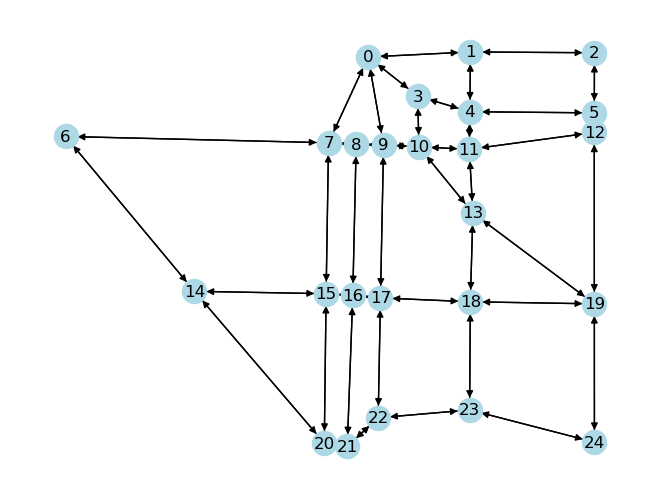

In [12]:
nx.draw(G,pos=coordinates,
        with_labels=True,
        node_color='lightblue')

## Example for a single Traveling Salesman

We are going to first find the optimal paths (shortest distance) for a single salesman that starts from the point of origin (0) and must pass through all points 1 to 24 and return to point 0.

In [13]:
n = G.number_of_nodes()
C = np.zeros((n, n)) 

for i in range(n):
    for j in range(n):
        if i != j:
            coord_i = nodes.loc[i, ['x', 'y']]
            coord_j = nodes.loc[j, ['x', 'y']]
            C[i, j] = euclidean(coord_i, coord_j)

# Showing distance matrix
print('Distance Matrix is:\n')
print(np.round(C,4))

Distance Matrix is:

[[0.     0.0443 0.0981 0.0228 0.0454 0.0986 0.132  0.0239 0.0177 0.0183
  0.0281 0.0473 0.0991 0.0546 0.0879 0.0495 0.0468 0.0471 0.065  0.1091
  0.0773 0.0762 0.0702 0.0814 0.1233]
 [0.0443 0.     0.0537 0.0244 0.0116 0.055  0.1762 0.064  0.0526 0.0417
  0.0289 0.0189 0.0559 0.0313 0.1283 0.0782 0.0695 0.0617 0.0485 0.0726
  0.0989 0.0934 0.0815 0.0695 0.0929]
 [0.0981 0.0537 0.     0.077  0.0552 0.0117 0.2297 0.1165 0.1047 0.0931
  0.0782 0.0574 0.0155 0.0612 0.1794 0.1253 0.1148 0.1042 0.0723 0.0488
  0.1394 0.1316 0.1175 0.088  0.0756]
 [0.0228 0.0244 0.077  0.     0.0228 0.0766 0.1528 0.0397 0.0282 0.0176
  0.0099 0.0246 0.0768 0.033  0.1039 0.0552 0.0478 0.0424 0.046  0.0865
  0.0786 0.0746 0.0648 0.065  0.1019]
 [0.0454 0.0116 0.0552 0.0228 0.     0.0539 0.1752 0.0615 0.0497 0.038
  0.0231 0.0073 0.054  0.0197 0.1243 0.0716 0.062  0.053  0.0369 0.0656
  0.0901 0.0839 0.0715 0.0579 0.0838]
 [0.0986 0.055  0.0117 0.0766 0.0539 0.     0.2291 0.1153 0.1033 0.091

In [14]:
# Defining variables
X = cp.Variable(C.shape, boolean=True)
u = cp.Variable(n, integer=True)
ones = np.ones((n,1))

# Defining the objective function
objective = cp.Minimize(cp.sum(cp.multiply(C, X)))

# Defining the constraints
constraints = []
constraints += [X @ ones == ones]
constraints += [X.T @ ones == ones]
constraints += [cp.diag(X) == 0]
constraints += [u[1:] >= 2]
constraints += [u[1:] <= n]
constraints += [u[0] == 1]

for i in range(1, n):
    for j in range(1, n):
        if i != j:
            constraints += [ u[i] - u[j] + 1  <= (n - 1) * (1 - X[i, j]) ]

prob = cp.Problem(objective, constraints)
prob.solve(verbose=False)

# Transforming the solution to a path
X_sol = np.argwhere(X.value==1)
orden = X_sol[0].tolist()

for i in range(1, n):
    row = orden[-1]
    orden.append(X_sol[row,1])

# Showing the optimal path
print('The path is:\n')
print( ' => '.join(map(str, orden)))

The path is:

0 => 9 => 8 => 7 => 6 => 14 => 20 => 21 => 22 => 15 => 16 => 17 => 18 => 23 => 24 => 19 => 12 => 5 => 2 => 1 => 4 => 11 => 13 => 10 => 3 => 0


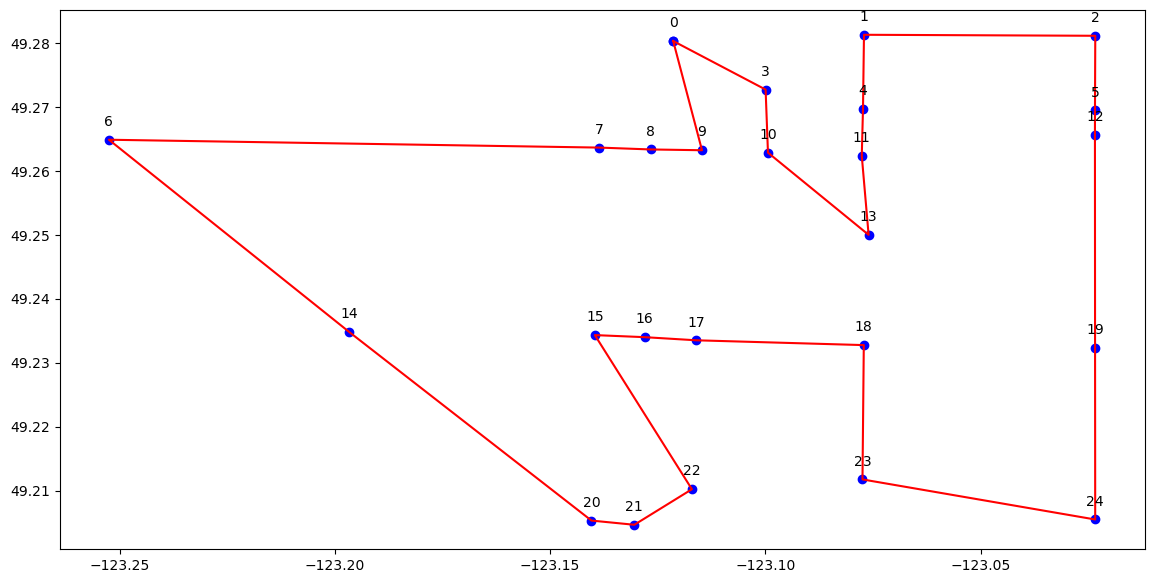

In [15]:
# Extract the coordinates for plotting
tour_coordinates = np.array([coordinates[i] for i in orden])

# Plot the points and annotate them
fig, ax = plt.subplots(figsize=(14, 7))
ax.scatter(tour_coordinates[:, 0], tour_coordinates[:, 1], c='blue')

for i in range(n):
    ax.annotate(orden[i], (tour_coordinates[i, 0], tour_coordinates[i, 1]), 
                textcoords="offset points", xytext=(0,10), ha='center')

ax.plot(tour_coordinates[:, 0], tour_coordinates[:, 1], c='red')
plt.show()

In [17]:
distance = np.sum(np.multiply(C, X.value))
print('The optimal distance is:', np.round(distance,2), 'units')

The optimal distance is: 0.7 units


## References

- CVXPY. *CVXPY: A Python-Embedded Modeling Language for Convex Optimization Problems*. Retrieved from [https://www.cvxpy.org/](https://www.cvxpy.org/)
- NEOS Guide. *Multiple Traveling Salesman Problem (MTSP)*. Retrieved from [https://neos-guide.org/case-studies/tra/multiple-traveling-salesman-problem-mtsp/](https://neos-guide.org/case-studies/tra/multiple-traveling-salesman-problem-mtsp/)
- Co-Enzyme. *Traveling Salesman Problem (TSP) in CPLEX OPL with Miller-Tucker-Zemlin (MTZ) formulation*. Retrieved from [https://co-enzyme.fr/blog/traveling-salesman-problem-tsp-in-cplex-opl-with-miller-tucker-zemlin-mtz-formulation/](https://co-enzyme.fr/blog/traveling-salesman-problem-tsp-in-cplex-opl-with-miller-tucker-zemlin-mtz-formulation/)
- NetworkX Developers. NetworkX Reference Documentation [Software documentation]. NetworkX. [https://networkx.org/documentation/stable/reference/index.html](https://networkx.org/documentation/stable/reference/index.html)
- OpenAI. ChatGPT [Software]. Available from https://openai.com/chatgpt